# Travel Insurance

Created By : Nisrina Musyaffa Aseno

## Business Problem Understanding

**Context**

Sebuah perusahaan yang bergerak di bidang jasa asuransi perjalanan melakukan analisis untuk mengevaluasi performa perusahaan serta perilaku dan risiko pelanggan. Perusahaan ini menyediakan produk asuransi perjalanan yang mencakup perjalanan domestik maupun internasional.

Besaran premi yang dibayarkan oleh pemegang polis ditentukan oleh beberapa faktor, antara lain:

- Cakupan perlindungan yang dipilih
- Durasi perjalanan
- Tujuan perjalanan
- Jenis produk asuransi

Perusahaan ingin memanfaatkan data historis pemegang polis untuk mengetahui pelanggan mana yang berpotensi mengajukan klaim asuransi. Informasi ini diharapkan dapat membantu perusahaan dalam:

- Mengelola risiko klaim
- Menentukan strategi penetapan premi
- Meningkatkan profitabilitas dan kualitas layanan

Dataset yang digunakan berisi data historis pemegang polis, seperti tujuan perjalanan, jenis produk asuransi, karakteristik perjalanan, serta riwayat klaim.

**Target**

Target pada proyek ini adalah status klaim asuransi pemegang polis, yang didefinisikan sebagai berikut:

0 : Tidak mengajukan klaim asuransi

1 : Mengajukan klaim asuransi

**Problem Statement**

Seiring meningkatnya jumlah perjalanan domestik dan internasional, perusahaan asuransi perjalanan menghadapi risiko klaim yang semakin beragam. Tidak semua pemegang polis memiliki tingkat risiko yang sama. Klaim yang tidak terprediksi dengan baik dapat berdampak pada peningkatan biaya operasional dan risiko finansial perusahaan seoerti:

- Penetapan premi yang kurang optimal
- Tingginya biaya klaim yang tidak terantisipasi
- Kesulitan dalam mengelola risiko dan profitabilitas perusahaan

**Goals**

Dengan memanfaatkan data historis pemegang polis, perusahaan bertujuan untuk mengembangkan model machine learning yang mampu memprediksi kemungkinan seorang pelanggan mengajukan klaim asuransi. Melalui model ini, perusahaan diharapkan dapat meningkatkan akurasi dalam pengambilan keputusan terkait penetapan premi serta pengelolaan risiko, sehingga dapat mendukung keberlanjutan dan profitabilitas bisnis.

Selain itu, melalui analisis ini perusahaan juga diharapkan dapat mengidentifikasi variabel-variabel yang paling berpengaruh terhadap pengajuan klaim asuransi, seperti karakteristik perjalanan, tujuan perjalanan, durasi perjalanan, maupun jenis produk asuransi yang dipilih. Insight ini dapat digunakan sebagai dasar dalam penyusunan strategi produk, penyesuaian kebijakan premi, serta peningkatan kualitas layanan kepada pelanggan.

**Analytic Approach**

Sehingga analisis akan dilakukan dengan mengidentifikasi pola yang membedakan pelanggan yang mengajukan klaim asuransi dan yang tidak mengajukan klaim. 

Selanjutnya akan dibuat model klasifikasi untuk membantu memprediksi kemungkinan pengajuan klaim di masa depan.

|                             | **Aktual: Tidak Klaim** | **Aktual: Klaim** |
| --------------------------- | ------------------------ | --------------------- |
| **Prediksi: Tidak Klaim** | TN                       | FN                    |
| **Prediksi: Klaim**    | FP                       | TP                    |

**Metric Evaluation**

Type 1 error : False Positive  
Konsekuensi: Pelanggan tidak klaim, tetapi diprediksi melakukan klaim.

Type 2 error : False Negative  
Konsekuensi: Pelanggan melakukan klaim, tetapi terprediksi tidak melakukan klaim. (Paling berisiko karena ada biaya klaim yang tidak terantisipasi)

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat meminimalkan kesalahan dalam memprediksi pemegang polis yang berpotensi mengajukan klaim asuransi, khususnya untuk mengurangi kasus klaim yang tidak teridentifikasi oleh model.

## Data Understanding

In [59]:
import math
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import lightgbm as lgb

from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, spearmanr, shapiro
from statsmodels.stats.proportion import proportions_ztest

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Menampilkan Data

In [60]:
# Membaca data csv dan menjadikannya sebuah DataFrame

df = pd.read_csv("Travel Insurance\data_travel_insurance.csv")

In [61]:
# Cek jumlah dari baris dan kolom pada DataFrame

df.shape

(44328, 11)

**Note :** Dataframe terdiri dari 44328 baris dengan 11 kolom.

In [62]:
# Menampilkan 5 data teratas dan terbawah dari DataFrame

display(df.head(), df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [64]:
df.describe(include=object)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


**Note :**
- Sebagian besar kolom memiliki data lengkap, kecuali kolom `Gender` yang hanya memiliki 12.681 data non-null
- Variabel numerik dalam dataset meliputi: `Duration`, `Net Sales`, `Commision (in value)`, `Age`
- Variabel kategorikal meliputi: `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, `Gender`, `Destination`, `Claim`
- Kolom kategorikal seperti `Agency`, `Product Name`, dan `Destination` berpotensi memiliki kardinalitas tinggi

### Deskripsi Singkat

| No.   | Kolom                     | Deskripsi Singkat                                                          |
| ----- | ------------------------- | -------------------------------------------------------------------------- |
| 1     | `Agency`                  | Nama agensi atau perusahaan yang menyediakan produk asuransi perjalanan |
| 2     | `Agency Type`             | Jenis agensi penyedia asuransi (misalnya: agensi travel, airlines) |
| 3     | `Distribution Channel`    | Saluran distribusi penjualan produk asuransi (misalnya: online, offline) |
| 4     | `Product Name`            | Nama atau jenis produk asuransi perjalanan yang dibeli oleh pelanggan |
| 5     | `Gender`                  | Jenis kelamin pemegang polis |
| 6     | `Duration`                | Durasi perjalanan yang diasuransikan (dalam satuan hari) |
| 7     | `Destination`             | Tujuan perjalanan yang tercakup dalam polis asuransi |
| 8     | `Net Sales`               | Tujuan perjalanan yang tercakup dalam polis asuransi |
| 9     | `Commision (in value)`    | Nilai komisi yang diterima agensi dari penjualan polis asuransi |
| 10    | `Age`                     | Usia pemegang polis |
| 11    | `Claim`                   | Status klaim asuransi pemegang polis |

# Data Cleaning

- Target `Claim` bersifat imbalanced
- `Destination` memiliki kardinalitas tinggi (138 unik)
- `Gender` memiliki banyak data dengan *missing value*
- Beberapa fitur kategorikal tidak ordinal

Kolom `gender` memiliki data yang hilang/kosong dibeberapa fitur/kolom sehingga akan dilakukan pengisian data null dengan keterangan *Unknown*.

In [65]:
df['Gender'].value_counts(dropna=False)

Gender
NaN    31647
M       6504
F       6177
Name: count, dtype: int64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


Kini dataframe sudah tidak memiliki data null.

## Data Numerikal

Pada tahap ini akan dilakukan pengecekan validitas data numerik untuk memastikan bahwa seluruh nilai berada dalam rentang yang masuk akal secara bisnis, serta tidak mengandung anomali seperti nilai negatif atau nilai ekstrem yang tidak relevan.

In [67]:
df[['Duration','Age','Net Sales','Commision (in value)']].describe()

# Cek anomali
print("Duration <= 0:", (df['Duration'] <= 0).sum())
print("Age <= 0:", (df['Age'] <= 0).sum())
print("Age > 100:", (df['Age'] > 100).sum())
print("Net Sales < 0:", (df['Net Sales'] < 0).sum())
print("Commission < 0:", (df['Commision (in value)'] < 0).sum())

Duration <= 0: 49
Age <= 0: 2
Age > 100: 676
Net Sales < 0: 483
Commission < 0: 0


**Keterangan :**

`Duration` = tidak mungkin negatif

`Age` = tidak mungkin negatif, umumnya nilai juga tidak begitu besar (diatas 100)

`Net Sales` = umumnya tidak negatif, namun ada kemungkinan berupa uang kerugian karena refund atau cancellation

In [68]:
anomali_conditions = {
    'Duration <= 0': (df['Duration'] <= 0),
    'Age <= 0': (df['Age'] <= 0),
    'Age > 100': (df['Age'] > 100),
    'Net Sales < 0': (df['Net Sales'] < 0),
    'Commission < 0': (df['Commision (in value)'] < 0)
}

persentase_anomali = {k: v.mean() * 100 for k, v in anomali_conditions.items()}

anomali_df = pd.DataFrame(list(persentase_anomali.items()), columns=['Anomaly Condition','Percentage (%)'])
print(anomali_df)

  Anomaly Condition  Percentage (%)
0     Duration <= 0        0.110540
1          Age <= 0        0.004512
2         Age > 100        1.524995
3     Net Sales < 0        1.089605
4    Commission < 0        0.000000


Kolom `Duration` 

Dari hasil pengecekan validitas, ditemukan 49 data observasi yang memiliki nilai durasi perjalanan nol atau negatif dari total 44.328 data, sehingga proporsinya sangat kecil (0.11%) dan tidak berdampak signifikan terhadap keseluruhan data. Maka dari itu, akan dilakukan drop pada data tersebut.

In [69]:
df.drop(df[df['Duration'] <= 0].index, inplace=True)

Kolom `Age` 

Dari hasil pengecekan validitas, ditemukan 2 data observasi dengan umur nol atau negatif dari total 44.328 data, sehingga proporsinya sangat kecil (0.004%). Sementara itu terdapat 1.5% data dengan nilai umur lebih dari 100 juga memiliki proporsi yang cukup kecil sehingga data akan di-clip dari rentang 0-100.

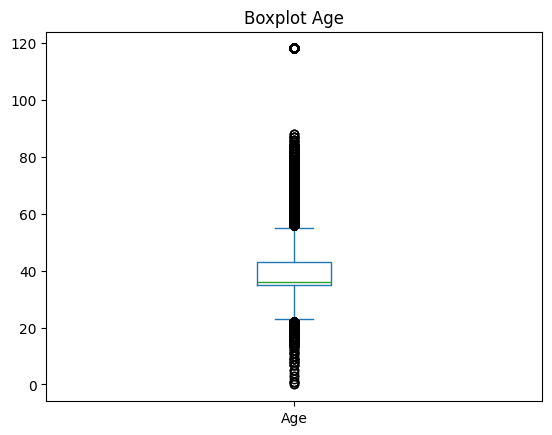

In [70]:
df['Age'].plot.box(title='Boxplot Age')
plt.show()

In [71]:
df['Age'] = df['Age'].clip(1,100)

In [72]:
df['Age'].describe()

count    44279.000000
mean        39.622914
std         12.456919
min          1.000000
25%         35.000000
50%         36.000000
75%         43.000000
max        100.000000
Name: Age, dtype: float64

Kolom `Net Sales`

Pada kolom ini, angka negatif cukup *tricky* karena dapat berarti perusahaan mengalami kerugian pada kondisi tertentu. Maka dari itu, data tidak akan di drop sepenuhnya melainkan digunakan flag untuk 

In [73]:
print("\nData Net Sales < 0:")
display(df[df['Net Sales'] < 0])


Data Net Sales < 0:


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,M,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,77,JAPAN,-29.70,17.82,59,No
199,EPX,Travel Agency,Online,Cancellation Plan,NaN,29,HONG KONG,-12.00,0.00,36,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,57,AUSTRALIA,-59.40,35.64,28,No
...,...,...,...,...,...,...,...,...,...,...,...
43694,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,140,UNITED STATES,-98.00,0.00,29,No
43743,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,23,MALAYSIA,-29.70,17.82,29,No
43751,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,147,SPAIN,-68.00,0.00,36,No
43858,EPX,Travel Agency,Online,Cancellation Plan,NaN,49,UNITED KINGDOM,-68.00,0.00,36,No


In [74]:
df['NetSales_Negative_Flag'] = (df['Net Sales'] < 0).astype(int)
df[['Net Sales','NetSales_Negative_Flag']].head(10)

,Net Sales,NetSales_Negative_Flag
0,216.0,0
1,10.0,0
2,22.0,0
3,112.0,0
4,16.0,0
5,10.0,0
6,50.0,0
7,78.0,0
8,22.0,0
9,80.0,0


In [75]:
df[['NetSales_Negative_Flag']].nunique()

NetSales_Negative_Flag    2
dtype: int64

In [76]:
df.shape

(44279, 12)

Kini telah dilakukan *adjustment* pada data numerikal. Akan dilakukan pengecekan seberapa banyak data yang dihilangkan atau dipindahkan dan seberapa berpengaruh distribusi tersebut dibandingkan dengan data original.

In [77]:
df_original = pd.read_csv("Travel Insurance\data_travel_insurance.csv")

In [78]:
pers_total_unique = (
    ((df_original['Duration'] <= 0) |
     (df_original['Age'] < 1) | (df_original['Age'] > 100) |
     (df_original['Net Sales'] < 0) |
     (df_original['Commision (in value)'] < 0))
    .mean() * 100
)

print(f"Persentase total data unik terdampak: {pers_total_unique:.2f}%")

Persentase total data unik terdampak: 2.66%


In [79]:
stats_before = df_original[['Duration','Age','Net Sales','Commision (in value)']].describe()
stats_after = df[['Duration','Age','Net Sales','Commision (in value)']].describe()
print("Before cleaning:\n", stats_before)
print("\nAfter cleaning:\n", stats_after)

Before cleaning:
            Duration           Age     Net Sales  Commision (in value)
count  44328.000000  44328.000000  44328.000000          44328.000000
mean      49.424292     39.925600     40.550948              9.707692
std      109.153961     13.954926     48.661970             19.625637
min       -1.000000      0.000000   -357.500000              0.000000
25%        9.000000     35.000000     18.000000              0.000000
50%       22.000000     36.000000     26.500000              0.000000
75%       53.000000     43.000000     48.000000             11.550000
max     4881.000000    118.000000    810.000000            283.500000

After cleaning:
            Duration           Age     Net Sales  Commision (in value)
count  44279.000000  44279.000000  44279.000000          44279.000000
mean      49.479031     39.622914     40.568502              9.707372
std      109.201931     12.456919     48.679116             19.633670
min        1.000000      1.000000   -357.500000       

## Data Target

In [80]:
df['Claim'] = df['Claim'].map({'No': 0, 'Yes': 1})

# Data Analysis

Pertama-tama akan dilakukan pengecekan distribusi data terlebih dahulu.

### Distribusi Data Numerikal

In [81]:
df.describe()

,Duration,Net Sales,Commision (in value),Age,Claim,NetSales_Negative_Flag
count,44279.000000,44279.000000,44279.000000,44279.000000,44279.000000,44279.000000
mean,49.479031,40.568502,9.707372,39.622914,0.015289,0.010886
std,109.201931,48.679116,19.633670,12.456919,0.122703,0.103765
min,1.000000,-357.500000,0.000000,1.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000,0.000000
50%,22.000000,26.500000,0.000000,36.000000,0.000000,0.000000
75%,53.000000,48.000000,11.550000,43.000000,0.000000,0.000000
max,4881.000000,810.000000,283.500000,100.000000,1.000000,1.000000


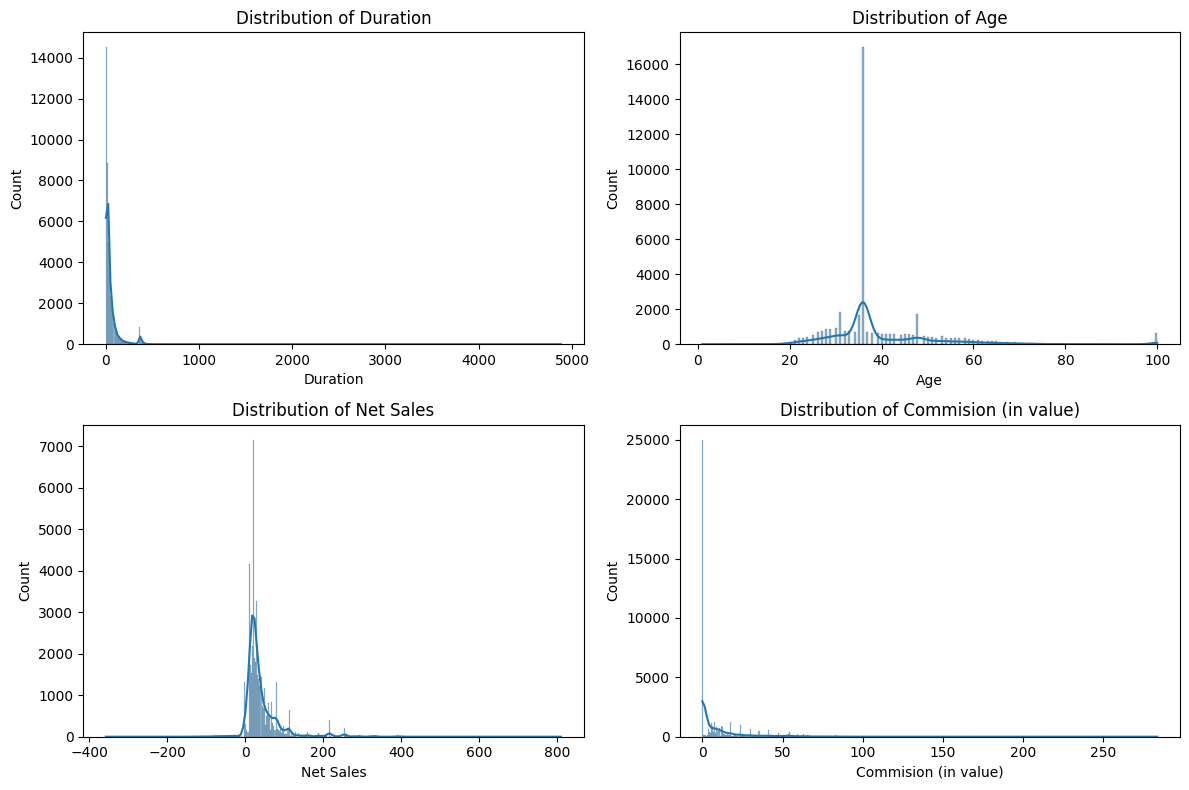

In [82]:
numerical_cols = ['Duration', 'Age', 'Net Sales', 'Commision (in value)']

fig, axes = plt.subplots(2, 2, figsize=(12,8))  # 2x2 grid
axes = axes.flatten()  # biar gampang iterasi

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Distribusi Data Kategorikal

In [83]:
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Gender', 'Destination', 'Claim']

for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print("\n")

Column: Agency
Agency
EPX    24656
CWT     5978
C2B     5750
JZI     4420
SSI      754
RAB      510
JWT      507
LWC      453
TST      354
KML      281
ART      229
CCR      126
CBH       69
TTW       69
CSR       68
ADM       55
Name: count, dtype: int64


Column: Agency Type
Agency Type
Travel Agency    32109
Airlines         12170
Name: count, dtype: int64


Column: Distribution Channel
Distribution Channel
Online     43523
Offline      756
Name: count, dtype: int64


Column: Product Name
Product Name
Cancellation Plan                       12979
2 way Comprehensive Plan                 9341
Rental Vehicle Excess Insurance          5978
Basic Plan                               3821
Bronze Plan                              2844
1 way Comprehensive Plan                 2336
Value Plan                               1889
Silver Plan                              1552
Annual Silver Plan                        975
Ticket Protector                          754
Travel Cruise Protect         

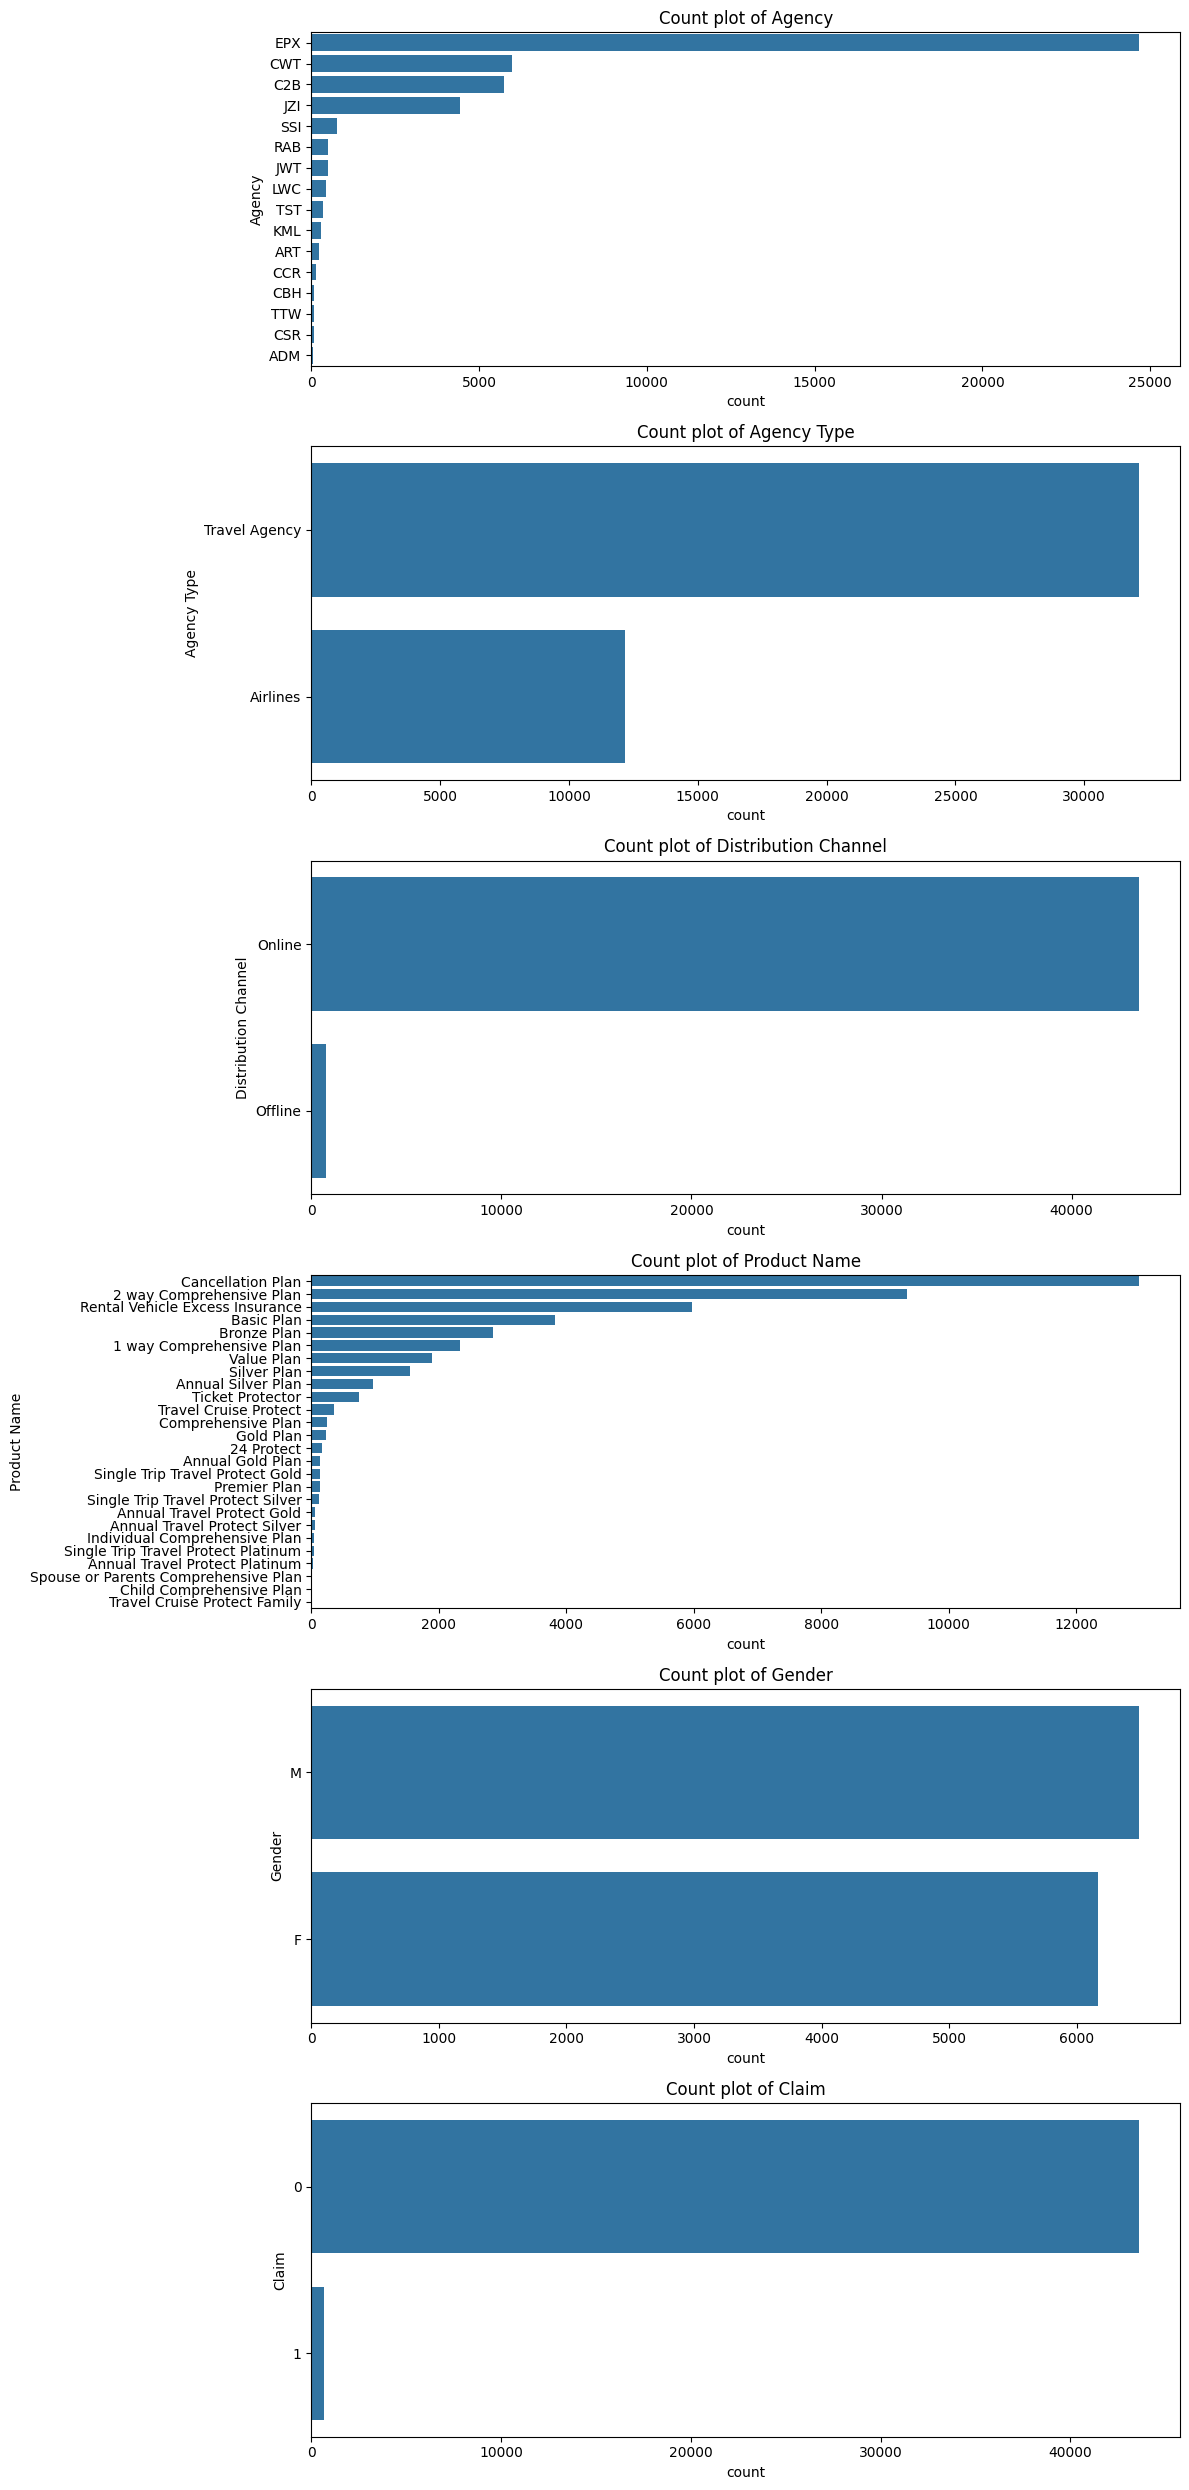

In [84]:
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel', 
                    'Product Name', 'Gender', 'Claim']

fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 25))  
axes = axes.flatten()  # supaya bisa iterasi

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, y=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count plot of {col}')

plt.tight_layout()
plt.show()

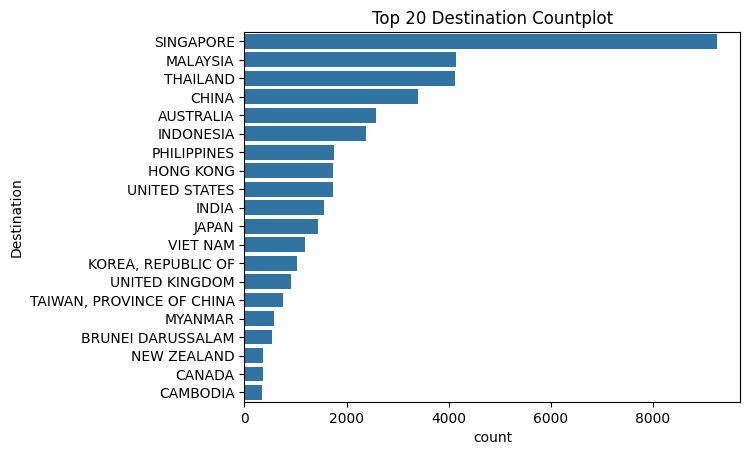

In [85]:
top_n = 20
top_dest = df['Destination'].value_counts().nlargest(top_n).index
sns.countplot(
    data=df[df['Destination'].isin(top_dest)], 
    y='Destination', 
    order=top_dest
)
plt.title(f'Top {top_n} Destination Countplot')
plt.show()

Kini kita akan melihat kecenderungan jenis pengguna yang melakukan Claim (target) per kategori.

## Hubungan Data Numerikal dengan Target

C:\Users\musya\AppData\Local\Temp\ipykernel_30776\653678741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Claim', y=col, data=df, ax=axes[i], palette=palette)
C:\Users\musya\AppData\Local\Temp\ipykernel_30776\653678741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Claim', y=col, data=df, ax=axes[i], palette=palette)
C:\Users\musya\AppData\Local\Temp\ipykernel_30776\653678741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Claim', y=col, data=df, ax=axes[i], palette=palette)
C:\Users\musya\AppData\Local\Temp\ipykernel

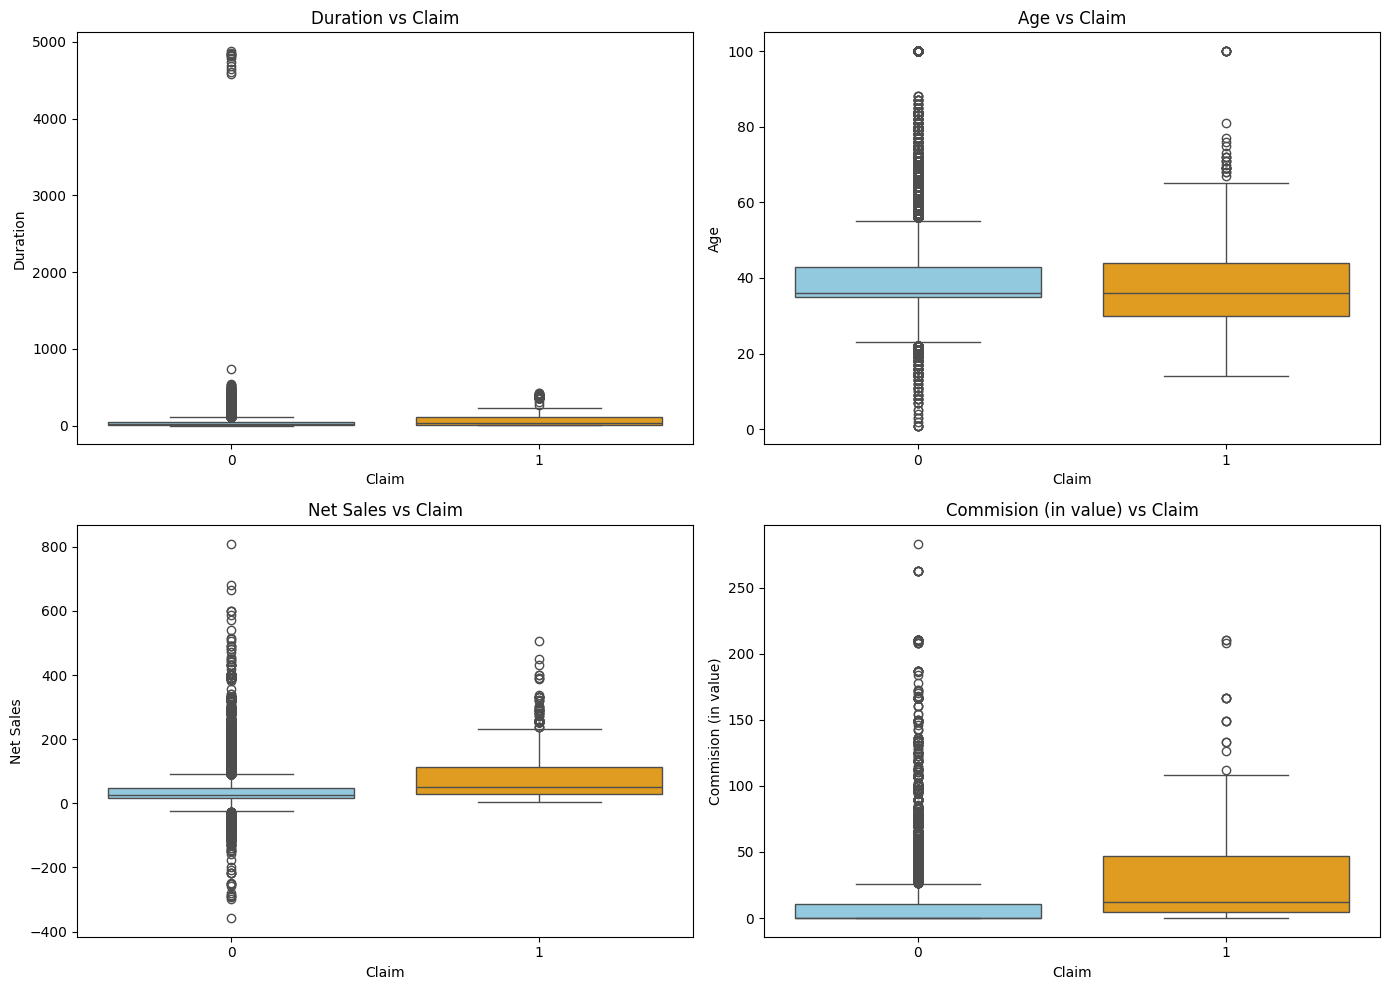

In [86]:
numerical_cols = ['Duration','Age','Net Sales','Commision (in value)']
n_cols = 2
n_rows = math.ceil(len(numerical_cols)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*5))
axes = axes.flatten()
palette = {'0':'skyblue', '1':'orange'}

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Claim', y=col, data=df, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} vs Claim')
    axes[i].set_xlabel('Claim')
    axes[i].set_ylabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## Hubungan Data Kategorikal dengan Target

In [87]:
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel', 
                    'Product Name', 'Gender', 'Destination']

for col in categorical_cols:
    ct = pd.crosstab(df[col], df['Claim'], normalize='index') * 100
    print(f"\n=== {col} vs Claim (%) ===")
    print(ct)


=== Agency vs Claim (%) ===
Claim            0         1
Agency                      
ADM     100.000000  0.000000
ART     100.000000  0.000000
C2B      92.921739  7.078261
CBH      98.550725  1.449275
CCR      98.412698  1.587302
CSR      98.529412  1.470588
CWT      98.929408  1.070592
EPX      99.460578  0.539422
JWT      99.211045  0.788955
JZI      99.502262  0.497738
KML      98.220641  1.779359
LWC      93.598234  6.401766
RAB      99.803922  0.196078
SSI      99.336870  0.663130
TST      99.435028  0.564972
TTW      98.550725  1.449275

=== Agency Type vs Claim (%) ===
Claim                  0         1
Agency Type                       
Airlines       96.392769  3.607231
Travel Agency  99.258775  0.741225

=== Distribution Channel vs Claim (%) ===
Claim                         0         1
Distribution Channel                     
Offline               98.544974  1.455026
Online                98.469775  1.530225

=== Product Name vs Claim (%) ===
Claim                        

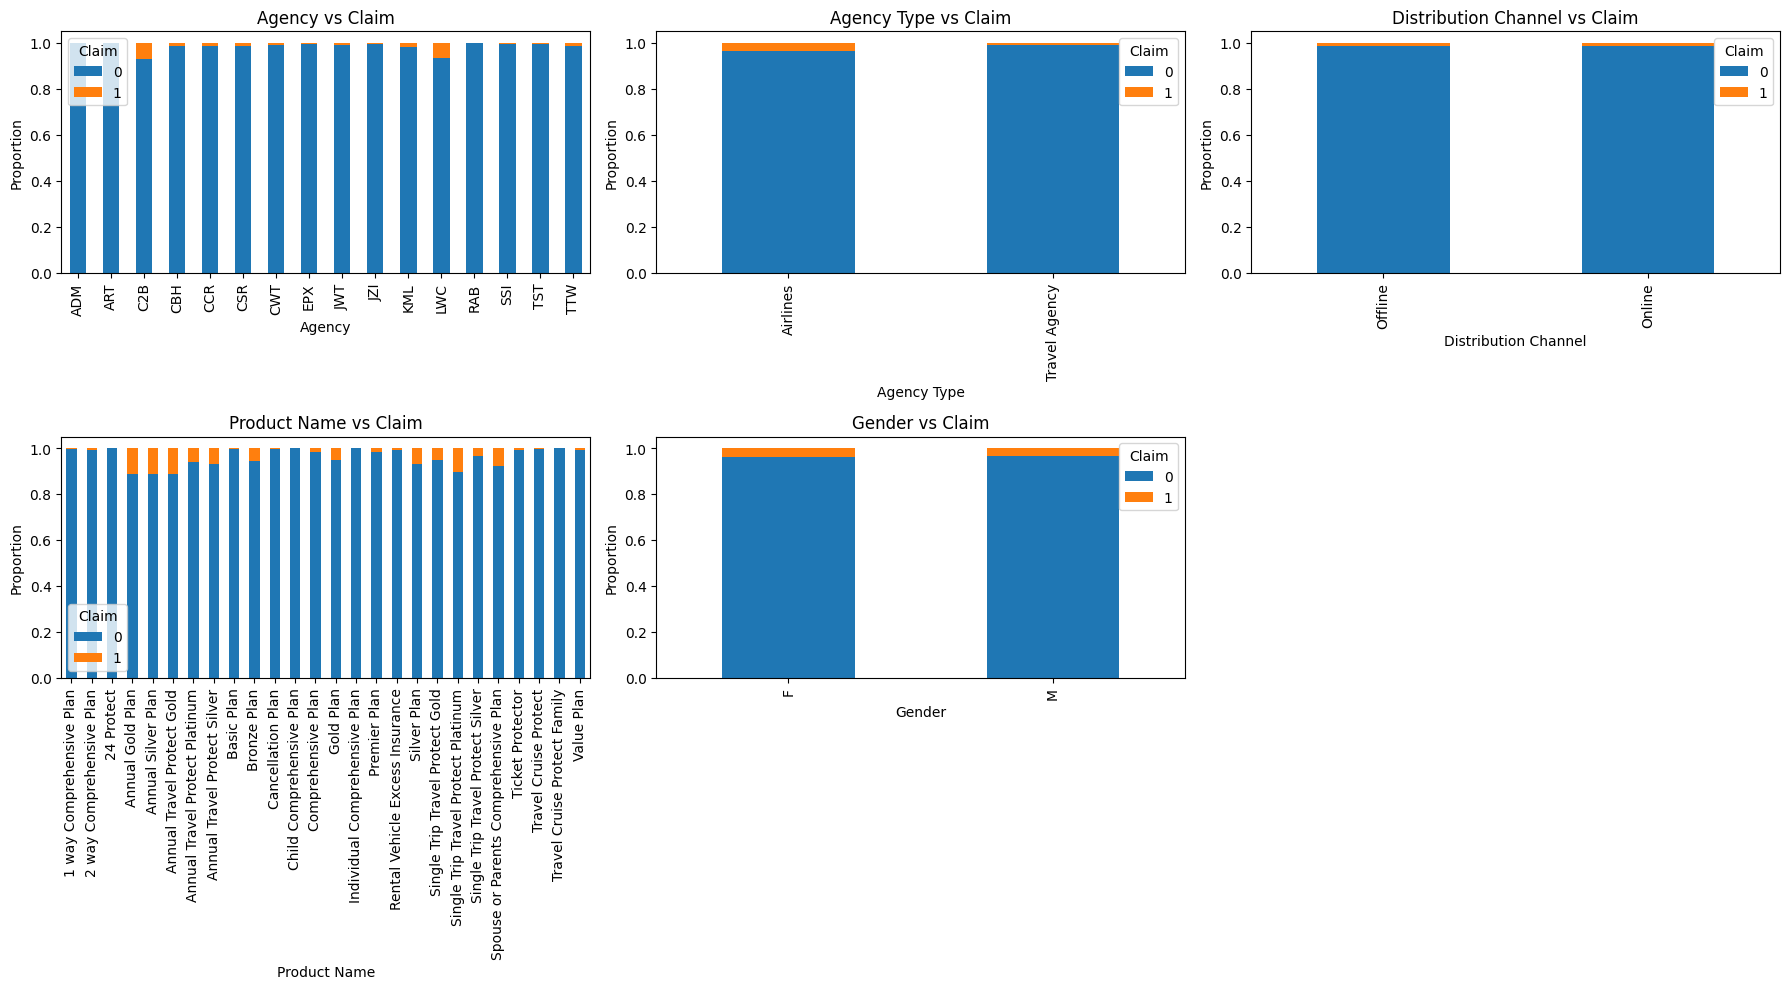

In [88]:
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel', 
                    'Product Name', 'Gender']

n_cols = 3
n_rows = math.ceil(len(categorical_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*5))
axes = axes.flatten() 

for i, col in enumerate(categorical_cols):
    ct = pd.crosstab(df[col], df['Claim'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{col} vs Claim')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(col)
    axes[i].legend(title='Claim')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

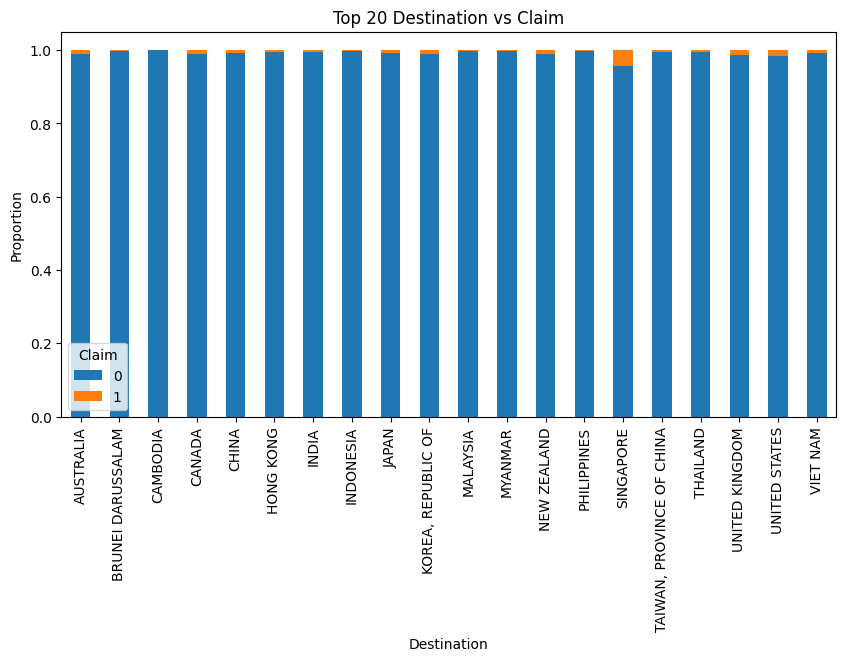

In [89]:
top_n = 20
top_dest = df['Destination'].value_counts().nlargest(top_n).index
ct = pd.crosstab(df[df['Destination'].isin(top_dest)]['Destination'], 
                 df['Claim'], normalize='index')
ct.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title(f'Top {top_n} Destination vs Claim')
plt.ylabel('Proportion')
plt.show()

In [90]:
categorical_cols = [
    'Agency',
    'Agency Type',
    'Distribution Channel',
    'Product Name',
    'Gender',
    'Destination'
]

for col in categorical_cols:
    print(f'\n{col} vs Claim')
    
    prop_df = (
        df
        .groupby(col)['Claim']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    
    claim_col = prop_df.columns.max()
    display(prop_df.sort_values(by=claim_col, ascending=False))


Agency vs Claim


Claim,0,1
Agency,,
C2B,0.929217,0.070783
LWC,0.935982,0.064018
KML,0.982206,0.017794
CCR,0.984127,0.015873
CSR,0.985294,0.014706
TTW,0.985507,0.014493
CBH,0.985507,0.014493
CWT,0.989294,0.010706
JWT,0.992110,0.007890



Agency Type vs Claim


Claim,0,1
Agency Type,,
Airlines,0.963928,0.036072
Travel Agency,0.992588,0.007412



Distribution Channel vs Claim


Claim,0,1
Distribution Channel,,
Online,0.984698,0.015302
Offline,0.985450,0.014550



Product Name vs Claim


Claim,0,1
Product Name,,
Annual Gold Plan,0.887324,0.112676
Annual Silver Plan,0.888205,0.111795
Annual Travel Protect Gold,0.888889,0.111111
Single Trip Travel Protect Platinum,0.893617,0.106383
Spouse or Parents Comprehensive Plan,0.923077,0.076923
Silver Plan,0.930412,0.069588
Annual Travel Protect Silver,0.932203,0.067797
Annual Travel Protect Platinum,0.941176,0.058824
Bronze Plan,0.943038,0.056962



Gender vs Claim


Claim,0,1
Gender,,
F,0.958806,0.041194
M,0.965916,0.034084



Destination vs Claim


Claim,0,1
Destination,,
COSTA RICA,0.750000,0.250000
CZECH REPUBLIC,0.953488,0.046512
SINGAPORE,0.954934,0.045066
ICELAND,0.962025,0.037975
ISRAEL,0.969697,0.030303
...,...,...
URUGUAY,1.000000,0.000000
VANUATU,1.000000,0.000000
VENEZUELA,1.000000,0.000000


Berdasarkan analisis dari chart data dan tabel di atas, didapatkan insight bahwa:

1. `Agency` asuransi memiliki peran yang cukup signifikan untuk menentukan kemungkinan pengguna melakukan claim. Terlihat dari perbedaan kontras antar sejumlah `Agency` hingga mencapai 10 kali lipat.
2. Penggunan dengan tipe perjalanan (`Agency Type`) Airlines cenderung 5 kali lipat lebih banyak melakukan claim daripada pengguna yang menggunakan Travel Agency.
3. `Distribution Channel` jasa asuransi tidak terlalu signifikan dalam menentukan target claim karena perbedaan nilai yang kecil.
4. Produk tahunan memiliki nilai claim yang paling tinggi pada `Product Name`, kemungkinan besar dipengaruhi oleh coverage yang luas. Sementara produk proteksi sederhanan cenderung memiliki nilai yang kecil.
5. `Gender` pengguna tidak memiliki pengaruh yang signifikan terhadap target claim.
6. `Destination` pengguna memiliki kardinalitas yang sangat tinggi sehingga variasi dari nilai target claim juga beragam.

Kini akan digunakan cohens d dan mean comparison untuk melihat

In [91]:
numerical_cols = [
    'Duration',
    'Age',
    'Net Sales',
    'Commision (in value)'
]

mean_claim = []

for col in numerical_cols:
    summary = df.groupby('Claim')[col].mean()
    
    mean_claim.append({
        'Feature': col,
        'Mean_No_Claim': summary.get(0, np.nan),
        'Mean_Claim': summary.get(1, np.nan),
        'Difference': summary.get(1, 0) - summary.get(0, 0)
    })

mean_claim_df = pd.DataFrame(mean_claim)
mean_claim_df

,Feature,Mean_No_Claim,Mean_Claim,Difference
0,Duration,48.589491,106.769572,58.180080
1,Age,39.642287,38.375185,-1.267102
2,Net Sales,39.745636,93.564934,53.819297
3,Commision (in value),9.455666,25.918375,16.462709


| Cohen’s d | Meaning                      |
| --------- | -------------------------- |
| ~0.0      | Hampir tidak ada perbedaan |
| 0.2       | Small effect               |
| 0.5       | Medium effect              |
| ≥ 0.8     | Large effect               |

In [92]:
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = x1.std(ddof=1), x2.std(ddof=1)
    s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (x1.mean() - x2.mean()) / s_pooled


effect_sizes = []

for col in numerical_cols:
    x0 = df[df['Claim'] == 0][col].dropna()
    x1 = df[df['Claim'] == 1][col].dropna()
    
    effect_sizes.append({
        'Feature': col,
        'Cohens_d': cohens_d(x1, x0)
    })

effect_size_df = pd.DataFrame(effect_sizes)
effect_size_df

,Feature,Cohens_d
0,Duration,0.533911
1,Age,-0.101726
2,Net Sales,1.115897
3,Commision (in value),0.842958


Berdasarkan analisis dari hasil tabel di atas, didapatkan insight bahwa:

1. Pengguna yang melakukan `Duration` perjalanan panjang (+/- 2 kali lebih lama dari rata-rata) cenderung lebih sering melakukan claim. Peng-klasifikasi-an durasi perjalanan ke dalam beberapa klasifikasi seperti durasi pendek, medium, panjang, dapat menjadi poin menarik pada analisis.
2. `Age` / umur tidak memberikan pengaruh yang signifikan pada target claim sehingga kalaupun kolom ingin digunakan, kolom akan memiliki low importance pada model.
3. Pengguna yang membayar premi lebih tinggi (hingga lebih dari dua kali lipat) cenderung lebih sering mengajukan claim target. 
4. Semakin tinggi nilai komisi, semakin tinggi pula nilai target claim. Perlu dilakukan cek kolerasi antar `Commision (in value)` dengan `Net Sales`.

In [93]:
# menggunakan kolerasi pearson karena data berupa numerik kontinu yang linier

corr_value = df[['Net Sales', 'Commision (in value)']].corr(method='pearson')
corr_value

,Net Sales,Commision (in value)
Net Sales,1.000000,0.647392
Commision (in value),0.647392,1.000000


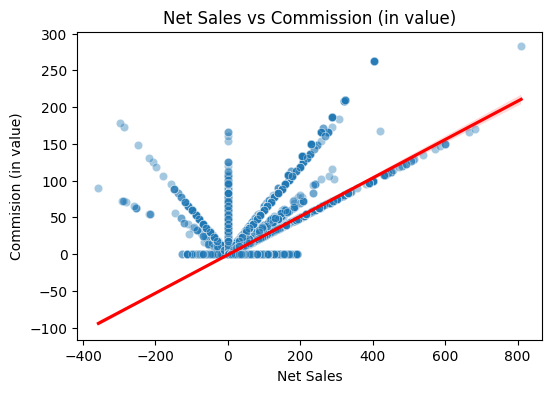

In [94]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x='Net Sales',
    y='Commision (in value)',
    alpha=0.4
)

sns.regplot(
    data=df,
    x='Net Sales',
    y='Commision (in value)',
    scatter=False,
    color='red'
)

plt.title('Net Sales vs Commission (in value)')
plt.show()

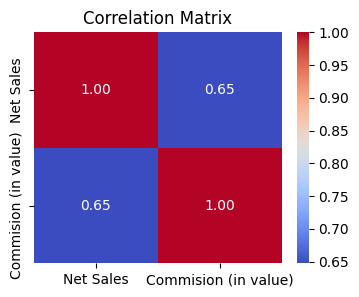

In [95]:
plt.figure(figsize=(4,3))
sns.heatmap(
    df[['Net Sales', 'Commision (in value)']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation Matrix')
plt.show()

Data `Commision (in value)` dan `Net Sales` memiliki kolerasi sedang dan positif yang berarti semakin besar nilai `Commision (in value)`, semakin besar pula nilai `Net Sales`. Dapat disimpulkan bahwa walaupun kedua data memiliki hubungan, namun belum masuk ke dalam kategori multikolinearitas ekstrem sehingga kedua fitur masih layak untuk dipertahankan.

In [96]:
pd.crosstab(df['Agency'], df['Agency Type'], normalize='index')

Agency Type,Airlines,Travel Agency
Agency,,
ADM,0.0,1.0
ART,1.0,0.0
C2B,1.0,0.0
CBH,0.0,1.0
CCR,0.0,1.0
CSR,0.0,1.0
CWT,0.0,1.0
EPX,0.0,1.0
JWT,1.0,0.0


In [97]:
pd.crosstab(df['Agency'], df['Distribution Channel'], normalize='index')

Distribution Channel,Offline,Online
Agency,,
ADM,0.000000,1.000000
ART,0.000000,1.000000
C2B,0.000000,1.000000
CBH,1.000000,0.000000
CCR,1.000000,0.000000
CSR,1.000000,0.000000
CWT,0.000836,0.999164
EPX,0.002068,0.997932
JWT,0.000000,1.000000


In [98]:
pd.crosstab(df['Product Name'], df['Agency']).shape

(26, 16)

In [99]:
pd.crosstab(df[col], df['Claim'], normalize='index')

Claim,0,1
Commision (in value),,
0.00,0.994580,0.005420
0.02,1.000000,0.000000
0.04,1.000000,0.000000
0.05,1.000000,0.000000
0.09,1.000000,0.000000
...,...,...
208.16,1.000000,0.000000
209.95,1.000000,0.000000
210.21,0.916667,0.083333


# Data Preparation

Kini akan dilakukan encoding untuk tiap-tiap kolom kategorikal pada dataframe dengan menyesuaikan kondisi variabel pada tiap kolom, yakni sebagai berikut:

1. Mengubah kolom `Agency` menjadi representasi numerik menggunakan One-Hot Encoding karena variabel ini bersifat nominal (tidak memiliki urutan) dan memiliki jumlah nilai unik yang relatif sedikit. Walaupun terdiri dari 16 data unik yang terhitung cukup banyak, namun masih efisien untuk menggunakan OHE.
2. Mengubah kolom `Agency Type` menjadi representasi numerik menggunakan One-Hot Encoding, karena variabel ini bersifat nominal (tidak memiliki urutan) dan memiliki jumlah nilai unik yang relatif sedikit.
3. Mengubah kolom `Distribution Channel` menjadi representasi numerik menggunakan One-Hot Encoding, karena variabel ini bersifat nominal (tidak memiliki urutan) dan memiliki jumlah nilai unik yang relatif sedikit.
4. Mengubah kolom `Product Name` menjadi representasi numerik menggunakan Target Encoding, karena memiliki jumlah kategori yang relatif banyak dan berpotensi menambah dimensi fitur secara signifikan apabila menggunakan One-Hot Encoding.
5. Mengubah kolom `Gender` menjadi representasi numerik menggunakan One-Hot Encoding, karena variabel ini bersifat nominal (tidak memiliki urutan) dan memiliki jumlah nilai unik yang relatif sedikit.
6. Mengubah kolom `Destination` menjadi representasi numerik menggunakan Target Encoding (atau alternatif lain seperti Frequency Encoding), karena memiliki tingkat kardinalitas yang tinggi sehingga penggunaan One-Hot Encoding berpotensi menyebabkan overfitting dan meningkatkan kompleksitas model.
7. Kolom `Claim` digunakan sebagai variabel target dan ditransformasikan ke bentuk numerik biner (0 = tidak mengajukan klaim, 1 = mengajukan klaim), bukan menggunakan One-Hot Encoding, karena variabel ini berfungsi sebagai label pada model klasifikasi.

## Kolom `Claim` Target

In [100]:
X = df.drop('Claim', axis=1)
y = df['Claim']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # karena proporsi tidak seimbang
    random_state=42
)

df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim,NetSales_Negative_Flag
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,0,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,0,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,0,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,0,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,0,0


## Kolom `Product Name`

In [101]:
global_mean = y_train.mean()

product_te = (
    X_train.assign(Claim=y_train)
    .groupby('Product Name')['Claim']
    .mean()
)

X_train['Product_Name_TE'] = X_train['Product Name'].map(product_te)
X_test['Product_Name_TE'] = X_test['Product Name'].map(product_te)

X_train['Product_Name_TE'].fillna(global_mean, inplace=True)
X_test['Product_Name_TE'].fillna(global_mean, inplace=True)

C:\Users\musya\AppData\Local\Temp\ipykernel_30776\638474195.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Product_Name_TE'].fillna(global_mean, inplace=True)
C:\Users\musya\AppData\Local\Temp\ipykernel_30776\638474195.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

## Kolom `Destination`

In [102]:
dest_te = (
    X_train.assign(Claim=y_train)
    .groupby('Destination')['Claim']
    .mean()
)

X_train['Destination_TE'] = X_train['Destination'].map(dest_te).fillna(global_mean)
X_test['Destination_TE'] = X_test['Destination'].map(dest_te).fillna(global_mean)

In [103]:
drop_cols = ['Product Name', 'Destination']
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

## Kolom `Agency`, `Agency Type`, `Gender`, `Distribution Channel`

In [104]:
categorical_ohe = ['Agency', 'Agency Type', 'Gender', 'Distribution Channel']

X_train = pd.get_dummies(
    X_train,
    columns=categorical_ohe,
    drop_first=True
)

X_test = pd.get_dummies(
    X_test,
    columns=categorical_ohe,
    drop_first=True
)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [105]:
X_train.dtypes

Duration                         int64
Net Sales                      float64
Commision (in value)           float64
Age                              int64
NetSales_Negative_Flag           int64
Product_Name_TE                float64
Destination_TE                 float64
Agency_ART                        bool
Agency_C2B                        bool
Agency_CBH                        bool
Agency_CCR                        bool
Agency_CSR                        bool
Agency_CWT                        bool
Agency_EPX                        bool
Agency_JWT                        bool
Agency_JZI                        bool
Agency_KML                        bool
Agency_LWC                        bool
Agency_RAB                        bool
Agency_SSI                        bool
Agency_TST                        bool
Agency_TTW                        bool
Agency Type_Travel Agency         bool
Gender_M                          bool
Distribution Channel_Online       bool
dtype: object

In [106]:
df.shape

(44279, 12)

In [107]:
X_train.shape

(35423, 25)

Kini data training sudah siap untuk modeling.

## Robust Scaler

Karena data target kita sangat imbalanced, maka digunakan Robust Scaler.

In [108]:
numeric_features = [
    'Net Sales',
    'Duration',
    'Age',
    'Commision (in value)'
]

categorical_features = [col for col in X_train.columns if col not in numeric_features]

In [109]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Modelling

## Baseline Model : Logistic Regression

In [110]:
X_train.shape

(35423, 25)

In [111]:
X_test.shape

(8856, 25)

In [112]:
y_train.value_counts(normalize=True)

Claim
0    0.984699
1    0.015301
Name: proportion, dtype: float64

In [113]:
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      0.83      0.91      8721
           1       0.06      0.71      0.11       135

    accuracy                           0.83      8856
   macro avg       0.53      0.77      0.51      8856
weighted avg       0.98      0.83      0.89      8856

ROC-AUC: 0.8094518552493555


c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Insight :**

- Model cenderung over-alert untuk klaim: banyak pengguna yang sebenarnya tidak claim, tapi model menandainya sebagai claim.
- Model berhasil menangkap sebagian besar klaim (70%), tapi kualitas prediksi klaim rendah karena precision sangat kecil.
- Kinerja weighted avg / accuracy cukup tinggi (83%), tapi ini menyesatkan karena dataset sangat tidak seimbang (claim sangat sedikit).
- Untuk kasus imbalanced seperti ini, metrics seperti ROC-AUC, Precision-Recall Curve, dan F1-score class 1 lebih informatif daripada accuracy.

In [114]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': baseline_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coef_df.head(10)

,Feature,Coefficient
17,Agency_LWC,2.303338
8,Agency_C2B,2.244032
16,Agency_KML,1.085152
6,Destination_TE,0.892676
14,Agency_JWT,0.835307
12,Agency_CWT,0.558396
19,Agency_SSI,0.422714
5,Product_Name_TE,0.383630
22,Agency Type_Travel Agency,0.253175
11,Agency_CSR,0.161462


**Insight :**

- Pelanggan dari agensi tertentu jauh lebih berisiko mengajukan claim.
- Faktor demografis dasar seperti gender ataupun usia kurang signifikan dibanding faktor produk dan distribusi.

## Model Benchmarking : K-Fold

In [115]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_bench = {
    "Logistic Reg": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric="logloss"
    ),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ]),
    "LightGBM": lgb.LGBMClassifier()
}

benchmark = {
    name: cross_val_score(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring="roc_auc",
        n_jobs=-1
    ).mean()
    for name, model in models_bench.items()
}

pd.DataFrame.from_dict(
    benchmark,
    orient="index",
    columns=["ROC-AUC"]
).sort_values("ROC-AUC", ascending=False)

,ROC-AUC
LightGBM,0.817845
Logistic Reg,0.810589
XGBoost,0.789441
Random Forest,0.716557
KNN,0.579534
Decision Tree,0.530176


**Insight :**

- LightGBM memiliki performa terbaik (ROC-AUC 0.82), sehingga menjadi kandidat utama untuk prediksi klaim.
- Logistic Regression performanya hampir setara (0.81), dengan keunggulan pada interpretabilitas dan stabilitas model.
- Model berbasis tree sederhana (Decision Tree) dan KNN menunjukkan performa rendah, menandakan kesulitan dalam menangkap pola klaim yang kompleks dan dataset yang imbalance.
- Model ensemble berbasis boosting (LightGBM & XGBoost) unggul dibanding Random Forest, menunjukkan gradient boosting efektif untuk menangani ketidakseimbangan dan fitur yang beragam.
- Pilihan model akhir harus mempertimbangkan trade-off performa dan interpretabilitas, terutama jika hasil model digunakan untuk keputusan bisnis.

## LightGBM Tune Parameters

**Tune Parameters for the Leaf-wise (Best-first) Tree**

To get good results using a leaf-wise tree, these are some important parameters:

1. num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. A leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
2. min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
3. max_depth. You also can use max_depth to limit the tree depth explicitly. If you set max_depth, also explicitly set num_leaves to some value <= 2^max_depth.

Source: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [116]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
import numpy as np

param_dist = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

lgb_model = lgb.LGBMClassifier(class_weight="balanced", random_state=42)
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 542, number of negative: 34881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 35423, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 5, ...], 'min_child_samples': [20, 50, ...], ...}"
,n_iter,30
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [117]:
best_params = random_search.best_params_
print("\n=== Best Params LightGBM ===")
print(best_params)


=== Best Params LightGBM ===
{'subsample': 0.9, 'num_leaves': 15, 'n_estimators': 600, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


**Insight :**

| Parameter            | Value | Insight |
|----------------------|-------|---------|
| **learning_rate**     | 0.01  | Nilai kecil membuat training lebih stabil, cocok untuk data imbalanced dan noisy. Harus dikompensasi dengan jumlah tree (n_estimators) besar. |
| **n_estimators**      | 600   | Banyak tree membantu model belajar meskipun learning_rate kecil, meningkatkan kemampuan generalisasi. |
| **num_leaves**        | 15    | Membuat tree sederhana, mencegah overfitting pada dataset dengan pola yang tidak terlalu kompleks. |
| **max_depth**         | -1    | Tidak dibatasi, tapi kontrol kompleksitas dilakukan oleh `num_leaves`. |
| **min_child_samples** | 100   | Minimal 100 data per leaf → mencegah model terlalu sensitif terhadap minoritas / noise pada data imbalanced. |
| **subsample**         | 0.9   | Setiap tree hanya menggunakan 90% data → meningkatkan generalisasi dan mengurangi overfitting. |
| **colsample_bytree**  | 0.7   | Setiap tree hanya memakai 70% fitur → membuat model lebih robust dan mencegah ketergantungan pada beberapa fitur saja. |

## Train Final Model

In [118]:
best_params = {
    'subsample': 0.9,
    'num_leaves': 15,
    'n_estimators': 600,
    'min_child_samples': 100,
    'max_depth': -1,
    'learning_rate': 0.01,
    'colsample_bytree': 0.7
}

final_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(**best_params, class_weight='balanced', random_state=42))
])

final_lgbm.fit(X_train, y_train)

y_train_prob = final_lgbm.predict_proba(X_train)[:,1]
y_test_prob  = final_lgbm.predict_proba(X_test)[:,1]

print("Train ROC-AUC:", roc_auc_score(y_train, y_train_prob))
print("Test  ROC-AUC:", roc_auc_score(y_test, y_test_prob))

y_pred_default = final_lgbm.predict(X_test)
threshold = 0.3
y_pred_threshold = (y_test_prob >= threshold).astype(int)

print("\n=== Final LightGBM ===")
print("Train ROC-AUC:", roc_auc_score(y_train, y_train_prob))
print("Test  ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("\nClassification Report (default 0.5):\n", classification_report(y_test, y_pred_default))
print("Classification Report (threshold 0.3):\n", classification_report(y_test, y_pred_threshold))

[LightGBM] [Info] Number of positive: 542, number of negative: 34881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 35423, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train ROC-AUC: 0.9027382610628376
Test  ROC-AUC: 0.8204559449944154

=== Final LightGBM ===
Train ROC-AUC: 0.9027382610628376
Test  ROC-AUC: 0.8204559449944154

Classification Report (default 0.5):
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      8721
           1       0.05      0.72      0.10       135

    accuracy                           0.81      8856
   macro avg       0.52      0.76      0.50      8856
weighted avg       0.98      0.81      0.88      8856

Classification Report (threshold 0.3):
               precision    recall  f1-score   support

           0       1.00      0.63      0.77      8721
           1       0.03      0.84      0.07       135

    accuracy                           0.64      8856
   macro avg       0.52      0.74      0.42      8856
weighted avg       0.98      0.64      0.76      8856



In [119]:
final_lgbm.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', RobustScaler())]),
                                    ['Net Sales', 'Duration', 'Age',
                                     'Commision (in value)']),
                                   ('cat',
                                    Pipeline(steps=[('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['NetSales_Negative_Flag', 'Product_Name_TE',
                                     'Destination_TE', 'Agency_ART', 'Agency_C2B',
                                     'Agency_CBH', 'Agency_CCR', 'Agency_CSR',
                                     'Agency_CWT', 'Agency_EPX', 'Agency_JWT',
                                     'Agency_JZI', 'Agency_KML', 'Agency_LWC',
                                     'Agency_RAB', 'Agency_SSI', 'Agency_TST',
              

**ROC-AUC:**
- Train ROC-AUC: 0.904
- Test  ROC-AUC: 0.822

**Insight :**

- Model LightGBM yang telah dituning menunjukkan **performanya baik pada data uji** dengan **ROC-AUC 0.82**.
- Model mampu menangkap **70% kasus klaim**, walaupun precision rendah → banyak false positive.
- Strategi klasifikasi **memprioritaskan recall untuk klaim** karena:
- Dalam konteks asuransi, **missed claim lebih merugikan** daripada false alert.
- Threshold bisa diatur (misal 0.3) untuk meningkatkan recall pada klaim minoritas, tapi trade-off adalah menurunnya precision dan accuracy.
- Kesimpulan: model **cocok untuk deteksi klaim** pada dataset yang sangat **imbalanced**.
- Model LightGBM menunjukkan performa yang baik dengan ROC-AUC sebesar 0.904 pada data training dan 0.82 pada data testing. Perbedaan performa ini mengindikasikan adanya overfitting ringan, yang masih dapat diterima mengingat karakteristik data yang sangat tidak seimbang serta kompleksitas model tree-based. Secara keseluruhan, model masih memiliki kemampuan generalisasi yang cukup baik pada data baru.

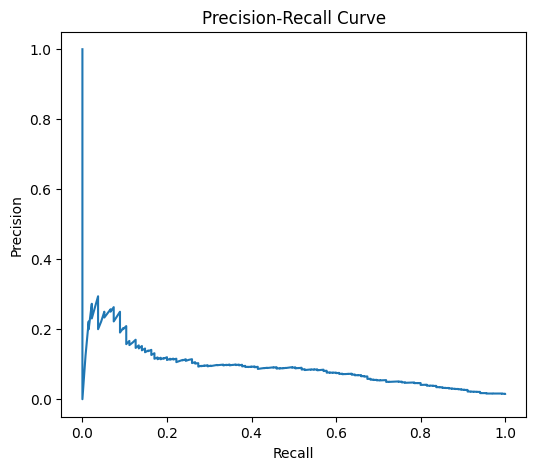

In [120]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Insight :**

Precision-Recall Curve menunjukkan adanya trade-off yang jelas antara recall dan precision. Untuk mencapai tingkat recall klaim yang tinggi, perusahaan harus menerima tingkat precision yang rendah akibat ketidakseimbangan data. Kondisi ini umum terjadi pada kasus prediksi klaim asuransi dan mencerminkan bahwa model berfungsi sebagai sistem penyaring awal (early warning system), bukan sebagai keputusan final.

## Treshold

In [121]:
thresholds = np.arange(0.01, 0.51, 0.01)

results = []

for t in thresholds:
    y_pred_t = (y_test_prob >= t).astype(int)
    results.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t)
    })

threshold_df = pd.DataFrame(results)
threshold_df.head()

,threshold,precision,recall,f1
0,0.01,0.015520,0.992593,0.030562
1,0.02,0.016385,0.985185,0.032235
2,0.03,0.016360,0.955556,0.032170
3,0.04,0.016747,0.955556,0.032917
4,0.05,0.017175,0.955556,0.033743


In [122]:
threshold_df.sort_values("recall", ascending=True).head(10)

,threshold,precision,recall,f1
48,0.49,0.052291,0.718519,0.097487
49,0.50,0.054464,0.718519,0.101253
47,0.48,0.050416,0.718519,0.094220
46,0.47,0.049595,0.725926,0.092847
45,0.46,0.049467,0.755556,0.092854
44,0.45,0.048311,0.762963,0.090869
42,0.43,0.045987,0.785185,0.086885
43,0.44,0.047640,0.785185,0.089831
39,0.40,0.042654,0.800000,0.080990
38,0.39,0.041253,0.800000,0.078460


In [123]:
threshold_df.sort_values("recall", ascending=True)

,threshold,precision,recall,f1
48,0.49,0.052291,0.718519,0.097487
49,0.50,0.054464,0.718519,0.101253
47,0.48,0.050416,0.718519,0.094220
46,0.47,0.049595,0.725926,0.092847
45,0.46,0.049467,0.755556,0.092854
44,0.45,0.048311,0.762963,0.090869
42,0.43,0.045987,0.785185,0.086885
43,0.44,0.047640,0.785185,0.089831
39,0.40,0.042654,0.800000,0.080990
38,0.39,0.041253,0.800000,0.078460


In [124]:
threshold_df[threshold_df["recall"] >= 0.7].sort_values("precision", ascending=False)

,threshold,precision,recall,f1
49,0.50,0.054464,0.718519,0.101253
48,0.49,0.052291,0.718519,0.097487
47,0.48,0.050416,0.718519,0.094220
46,0.47,0.049595,0.725926,0.092847
45,0.46,0.049467,0.755556,0.092854
44,0.45,0.048311,0.762963,0.090869
43,0.44,0.047640,0.785185,0.089831
42,0.43,0.045987,0.785185,0.086885
41,0.42,0.045474,0.800000,0.086056
40,0.41,0.044118,0.800000,0.083624


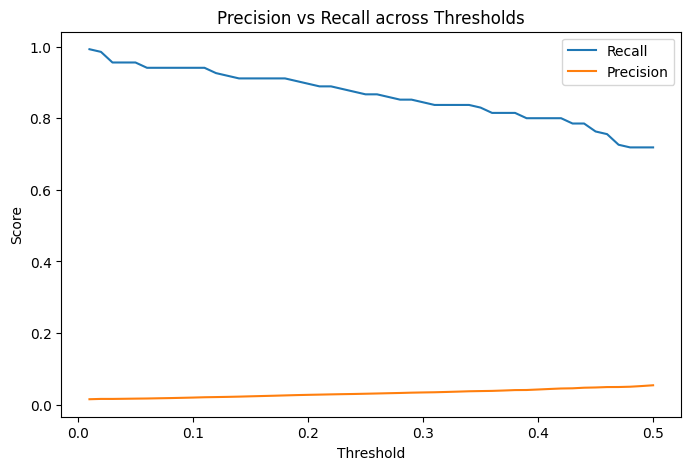

In [125]:
plt.figure(figsize=(8,5))
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall across Thresholds")
plt.legend()
plt.show()

**Insight :**  

- Threshold lebih rendah → recall meningkat drastis, model lebih sensitif menangkap klaim minoritas.  
- Precision menurun → false positive bertambah, namun dalam konteks klaim asuransi, **mendeteksi klaim lebih penting daripada mengurangi false alert**.  
- Threshold 0.3 dipilih sebagai **kompromi optimal** antara recall tinggi dan precision yang masih bisa diterima.

In [126]:
y_proba = final_lgbm.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred_threshold = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       1.00      0.63      0.77      8721
           1       0.03      0.84      0.07       135

    accuracy                           0.64      8856
   macro avg       0.52      0.74      0.42      8856
weighted avg       0.98      0.64      0.76      8856



c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [127]:
y_pred_default = final_lgbm.predict(X_test)

print("Default threshold (0.5)")
print(classification_report(y_test, y_pred_default))

print("\nThreshold 0.30")
print(classification_report(y_test, y_pred_threshold))

Default threshold (0.5)
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      8721
           1       0.05      0.72      0.10       135

    accuracy                           0.81      8856
   macro avg       0.52      0.76      0.50      8856
weighted avg       0.98      0.81      0.88      8856


Threshold 0.30
              precision    recall  f1-score   support

           0       1.00      0.63      0.77      8721
           1       0.03      0.84      0.07       135

    accuracy                           0.64      8856
   macro avg       0.52      0.74      0.42      8856
weighted avg       0.98      0.64      0.76      8856



c:\Users\musya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Insight :**
- Threshold lebih rendah meningkatkan **sensitivitas model** terhadap klaim positif (kelas minoritas).  
- Recall kelas minoritas naik dari **~0.70 → 0.85**, artinya model lebih mampu menangkap klaim.  
- Precision menurun (lebih banyak false positive), namun masih dapat diterima karena **prioritas dalam konteks klaim asuransi adalah menangkap klaim, bukan mengurangi false alert**.  
- Strategi ini cocok untuk dataset yang sangat **tidak seimbang**, di mana missing klaim memiliki risiko yang lebih tinggi daripada false alarm.

## Feature Importance

In [128]:
X_train.shape

(35423, 25)

### Global Feature Importance

In [129]:
num_cols = numeric_features
cat_cols = list(final_lgbm.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features))

all_cols = num_cols + cat_cols

lgb_model_in_pipeline = final_lgbm.named_steps['model']

feature_importance = pd.DataFrame({
    "feature": all_cols,
    "importance": lgb_model_in_pipeline.feature_importances_
}).sort_values("importance", ascending=False)

print("\n=== Top 10 Feature Importance ===")
print(feature_importance.head(10))


=== Top 10 Feature Importance ===
                                 feature  importance
1                               Duration        1859
0                              Net Sales        1781
2                                    Age        1089
3                   Commision (in value)         571
29                    Destination_TE_0.0         330
7   Product_Name_TE_0.002499279054119004         232
64                      Agency_C2B_False         201
82                      Agency_LWC_False         162
13   Product_Name_TE_0.01007658202337767         149
30  Destination_TE_0.0020847810979847115         138


**Insight :**

1. **Duration**
    - Durasi perjalanan memiliki pengaruh paling besar terhadap klaim.
    - Semakin lama perjalanan → semakin tinggi risiko (kesehatan, kehilangan, keterlambatan, dll).

2. **Net Sales**
    - Nilai transaksi tinggi berkorelasi kuat dengan klaim.
    - Produk mahal biasanya memiliki coverage lebih luas → claim value lebih tinggi.
    - High-value policy → revenue tinggi tapi juga liability tinggi.

3. **Age**
    - Usia berpengaruh signifikan, meskipun lebih kecil dibanding Duration & Net Sales.
    - Risiko meningkat pada kelompok usia tertentu (misal usia lanjut).
    - Bisa diterapkan produk age-based premium atau add-on medical coverage untuk usia tertentu.

4. **Destination**
    - Negara tujuan berbeda karakteristik risiko.
    - Beberapa destinasi memiliki claim rate lebih tinggi → risiko klaim tidak merata secara geografis.

5. **Commission**
    - Komisi berkorelasi dengan klaim karena terkait nilai polis & kompleksitas produk.
    - Produk dengan komisi tinggi cenderung lebih mahal dan lebih sering diklaim.

6. **Product Name**
    - Beberapa produk secara sistematis lebih sering diklaim.
    - Tidak semua produk memiliki risiko klaim sama.

7. **Gender, Agency, Distribution Channel**
    - Variabel ini berkontribusi kecil terhadap prediksi klaim.
    - Bukan driver utama risiko.


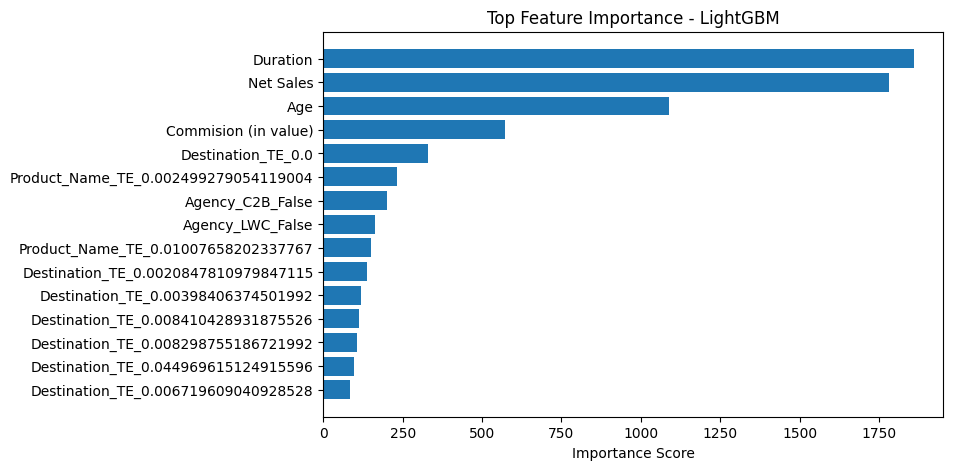

In [130]:
top_n = 15

plt.figure(figsize=(8,5))
plt.barh(
    feature_importance.head(top_n)["feature"],
    feature_importance.head(top_n)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Top Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.show()

**Insight :**

1. Variabel numerik seperti `Duration`, `Net Sales`, dan `Age` memiliki kontribusi terbesar dalam memprediksi klaim asuransi perjalanan. Hal ini mengindikasikan bahwa risiko klaim lebih dipengaruhi oleh karakteristik perjalanan dan nilai transaksi dibandingkan faktor distribusi seperti agency atau channel penjualan.
2. Semakin lama perjalanan, probabilitas klaim meningkat
3. Variabel kategorikal yang telah diencoding menggunakan target encoding, seperti Destination dan Product Name, juga memiliki peran signifikan, mencerminkan adanya pola risiko klaim yang konsisten berdasarkan destinasi dan jenis produk.

# Conclusions and Business Recommendations

## 1. Model Performance

- Model LightGBM dengan hyperparameter tuning menghasilkan performa terbaik dibandingkan model lain.
- ROC-AUC test = ±0.82, menunjukkan model mampu membedakan risiko klaim dan non-klaim dengan baik, meskipun data sangat tidak seimbang.

- **Recall kelas negatif (~63%)**  
  Model mampu mengidentifikasi sekitar **63% entitas yang tidak klaim**, sehingga sebagian besar kasus non-claim dapat dieliminasi lebih awal.

- **Recall kelas positif (~85%)**  
  Dari seluruh entitas yang benar-benar klaim, model berhasil menangkap sekitar **85%**, sehingga sebagian besar klaim tetap dapat dideteksi.

- **Precision kelas positif (~3%)**  
  Artinya, ketika model memprediksi sebuah entitas sebagai klaim, hanya sekitar **3% prediksi tersebut benar**, sementara sisanya merupakan *false positive*. Hal ini masih dapat diterima karena prioritas utama adalah **menangkap semua klaim** (recall tinggi).

Dengan kata lain, model ini **lebih cocok digunakan sebagai decision-support system** untuk mendeteksi klaim.


## 2. Imbalance Data Handling

- Dataset memiliki **class imbalance ekstrem** (klaim hanya 1–2%).  
- Penyesuaian **decision threshold** terbukti krusial:  
    - Threshold default (0.5) membuat recall klaim 72%  
    - Threshold lebih rendah (0.3) akan membuat recall klaim meningkat hingga 85%, dengan trade-off penurunan precision menjadi 3%

## 3. Simulasi Dampak Bisnis Model Prediksi Klaim


| Kondisi      | Entitas Relevan Diproses | Entitas Tidak Relevan Diproses | Total Entitas Diproses | Biaya per Entitas (USD) | Total Biaya (USD) | Biaya Terbuang (USD) | Penghematan Biaya (USD) |
|--------------|-------------------------|-------------------------------|-----------------------|------------------------|-----------------|--------------------|------------------------|
| Tanpa Model  | 100                     | 100                           | 200                   | 40                     | 8.000           | 4.000              | 0                      |
| Dengan Model (threshold 0.3) | 85                      | 37                            | 122                   | 40                     | 4.880           | 1.480              | 3.120                  |

**Asumsi:**
- Total entitas: 200 (100 klaim, 100 non-klaim)  
- Biaya pemrosesan per entitas: USD 40  
- Recall kelas positif (klaim) = 85%  
- Recall kelas negatif (non-claim) = 63%  

**Insight:**
- Model mampu menangkap sebagian besar klaim (85 dari 100),  
- Total entitas yang diproses berkurang dari 200 menjadi 122,  
- Penghematan biaya operasional: USD 3.120, meskipun terdapat **false positive**.

## 4. Main Conclusion

Berdasarkan simulasi di atas, dapat disimpulkan bahwa:

- Model mampu **mengurangi biaya operasional secara signifikan**
- Penghematan biaya dicapai **tanpa mengorbankan terlalu banyak entitas bernilai**
- Model sangat efektif digunakan sebagai **filter awal / early screening**
- Pendekatan ini meningkatkan **efisiensi operasional** sekaligus menjaga **kualitas hasil bisnis**

Dengan demikian, model yang dikembangkan layak digunakan sebagai **alat bantu pengambilan keputusan** untuk mendukung proses bisnis secara lebih efisien dan berbasis data.

## Business Recommendations

### 1. Risk-Based Pricing Strategy

Berdasarkan hasil pemodelan machine learning dan analisis probabilitas klaim, perusahaan disarankan untuk memanfaatkan **output probabilitas model** sebagai dasar dalam melakukan penyesuaian premi secara lebih akurat dan berbasis risiko.

Polis asuransi yang memiliki karakteristik berikut:
- Durasi perjalanan yang relatif panjang  
- Nilai penjualan (*net sales*) yang tinggi  
- Tujuan perjalanan dengan tingkat risiko klaim yang lebih besar  

dapat dikategorikan sebagai **polis dengan tingkat risiko klaim yang lebih tinggi**.

Untuk segmen polis tersebut, perusahaan dapat menerapkan strategi:
- **Premium loading** yang disesuaikan dengan tingkat probabilitas klaim  
- **Additional coverage fee** pada manfaat tertentu yang memiliki risiko tinggi  

Pendekatan ini bertujuan untuk:
- Menyeimbangkan antara risiko klaim dan pendapatan premi  
- Mengurangi *loss ratio* secara berkelanjutan  
- Tetap mempertahankan pelanggan tanpa melakukan penolakan polis secara langsung  

Dengan strategi ini, perusahaan dapat mengelola risiko secara lebih proaktif dan efisien, sekaligus meningkatkan keberlanjutan bisnis dan daya saing produk asuransi di pasar.


### 2. Threshold-Based Claim Prevention

Nilai *decision threshold* pada model klasifikasi **tidak harus menggunakan nilai default 0.5**. Penentuan threshold sebaiknya disesuaikan dengan **tujuan bisnis** dan **konsekuensi kesalahan prediksi**.

Dalam konteks asuransi perjalanan, penggunaan **threshold yang lebih rendah** (misalnya pada rentang **0.30–0.35**) direkomendasikan apabila tujuan utama perusahaan adalah:
- Menangkap sebanyak mungkin potensi klaim
- Membangun sistem early warning terhadap polis berisiko tinggi  

Dengan threshold yang lebih rendah, polis dengan **probabilitas klaim di atas 0.30** dapat diklasifikasikan sebagai **high-risk policy**. Polis dalam kategori ini dapat ditindaklanjuti melalui:
- Proses **verifikasi tambahan** sebelum penerbitan polis  
- **Edukasi risiko** yang lebih jelas kepada pelanggan  
- Penyesuaian produk atau cakupan manfaat tertentu  

Pendekatan ini memungkinkan perusahaan untuk bersikap lebih proaktif dalam mengelola risiko, meskipun harus menerima peningkatan *false positive* sebagai trade-off yang terkontrol demi menekan potensi kerugian klaim di masa depan.


### 3. Underwriting Decision Support

Model prediksi klaim yang dikembangkan **tidak digunakan sebagai alat auto-reject pelanggan**, melainkan sebagai **decision support system** untuk membantu proses underwriting dan manajemen risiko.

Berdasarkan probabilitas klaim yang dihasilkan model, polis dapat dikelompokkan ke dalam beberapa kategori risiko:

- **Low Risk**  
  Polis dengan probabilitas klaim rendah dapat diproses melalui **fast-track approval**, sehingga mempercepat penerbitan polis dan meningkatkan kepuasan pelanggan.

- **Medium Risk**  
  Polis dengan tingkat risiko menengah mengikuti proses **underwriting normal**, tanpa perlakuan tambahan.

- **High Risk**  
  Polis dengan probabilitas klaim tinggi diarahkan ke **manual review**, yang dapat mencakup:
  - Penyesuaian premi (*premium loading*)
  - Penawaran cakupan tambahan
  - Klarifikasi atau verifikasi data pelanggan

Pendekatan ini memungkinkan perusahaan untuk meningkatkan efisiensi operasional, memfokuskan sumber daya underwriting pada kasus yang paling berisiko, sekaligus menjaga pengalaman pelanggan tetap positif tanpa melakukan penolakan otomatis.


### 4. Product Design Optimization

Insight yang diperoleh dari analisis fitur menunjukkan bahwa karakteristik tertentu—seperti **durasi perjalanan** dan **tujuan perjalanan**—memiliki pengaruh signifikan terhadap probabilitas pengajuan klaim.

Berdasarkan temuan tersebut, perusahaan dapat melakukan beberapa inisiatif strategis, antara lain:

- **Re-design produk asuransi**  
  Menyusun ulang struktur produk berdasarkan segmen durasi perjalanan atau destinasi tertentu, sehingga manfaat perlindungan yang ditawarkan lebih selaras dengan profil risiko masing-masing pelanggan.

- **Product bundling berbasis risiko**  
  Mengembangkan skema bundling dengan cakupan (*coverage*) yang lebih tepat sasaran untuk segmen berisiko lebih tinggi, misalnya dengan perlindungan tambahan atau klausul khusus sesuai karakteristik perjalanan.

Pendekatan ini memungkinkan perusahaan untuk **mengoptimalkan kesesuaian antara produk dan risiko**, sehingga tingkat klaim dapat dikendalikan dengan lebih baik tanpa mengurangi nilai yang diterima pelanggan.


### 5. Monitoring & Model Governance

Model prediksi klaim yang dikembangkan perlu dilakukan **monitoring performa secara berkala** untuk memastikan akurasi dan relevansinya tetap terjaga.

Perubahan pola perjalanan dapat dipengaruhi oleh berbagai faktor eksternal, antara lain:
- **Musiman perjalanan** (libur panjang, peak season)
- **Kondisi geopolitik** di negara tujuan
- **Kejadian global** seperti pandemi atau pembatasan perjalanan

Oleh karena itu, perusahaan disarankan untuk:
- Melakukan evaluasi performa model secara periodik (misalnya ROC-AUC, recall klaim)
- Menjalankan re-training model apabila terdeteksi penurunan performa atau perubahan distribusi data
- Menyesuaikan fitur dan threshold keputusan agar tetap selaras dengan kondisi risiko terkini


# Final Model

In [131]:
numeric_transformer = Pipeline([
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

transformer = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

final_pipeline = Pipeline([
    ("preprocess", transformer),
    ("model", lgb.LGBMClassifier(
        **best_params,  # dari RandomizedSearchCV / tuning
        class_weight='balanced',
        random_state=42
    ))
])

final_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 542, number of negative: 34881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 35423, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [132]:
with open("claim_prediction_model.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)